<a href="https://colab.research.google.com/github/swjh9523/Python_Tutorial/blob/master/%EC%BD%94%EB%A1%9C%EB%82%98_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime as dt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


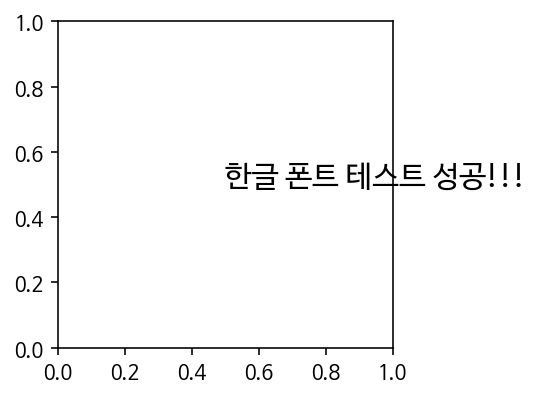

In [3]:
# 그래프 한글폰트 사용설정 in Colab
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fontpath = '/content/drive/My Drive/파이썬/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## Test
plt.figure(figsize=(3,3))
plt.text(0.5, 0.5, '한글 폰트 테스트 성공!!!', size=15)
plt.show()

## 전처리

In [4]:
card = pd.read_csv('/content/drive/MyDrive/공모전데이터파일/COVID-19/card_20200717.csv', encoding="UTF-8")
adstrd_master = pd.read_csv('/content/drive/MyDrive/공모전데이터파일/COVID-19/adstrd_master.csv', encoding="UTF-8")
fpopl = pd.read_csv('/content/drive/MyDrive/공모전데이터파일/COVID-19/fpopl.csv')
delivery = pd.read_csv('/content/drive/MyDrive/공모전데이터파일/COVID-19/delivery.csv')

In [5]:
card.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000


In [6]:
card.columns = ["접수일자","행정동 코드", "행정동 명", "업종 코드", "업종 명", "발생 건수", "발생 금액"]
card["접수일자"] = card["접수일자"].astype('str').apply(lambda x : x[:4] + '-' + x[4:6] + '-' + x[6:])
adstrd_master.columns = ["행정동 코드", "행정동","광역시도","시군구"]

In [7]:
# 병합을 위한 글자길이 확인
print(card["행정동 코드"].astype('str').str.len())
print(adstrd_master["행정동 코드"].astype('str').str.len())

# 데이터 병합을 위해 데이터 길이 맞추기
adstrd_master["행정동 코드"] = adstrd_master["행정동 코드"].astype('int')
adstrd_master["행정동 코드"] = adstrd_master["행정동 코드"].astype('str').apply(lambda x: x[0:] + '00').astype('int')

# df로 병합하기(행정동 코드 기준 left)
card2 = pd.merge(card, adstrd_master,on = '행정동 코드' ,how='left').copy()
card2.head()


0          10
1          10
2          10
3          10
4          10
           ..
3713947    10
3713948    10
3713949    10
3713950    10
3713951    10
Name: 행정동 코드, Length: 3713952, dtype: int64
0       10
1       10
2       10
3       10
4       10
        ..
3488    10
3489    10
3490    10
3491    10
3492    10
Name: 행정동 코드, Length: 3493, dtype: int64


,접수일자,행정동 코드,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,행정동,광역시도,시군구
0,2020-01-04,1174066000,성내3동,7041,약국,463,5843230,성내3동,서울특별시,강동구
1,2020-01-04,1174066000,성내3동,7022,치과의원,33,7835550,성내3동,서울특별시,강동구
2,2020-01-04,1174066000,성내3동,7021,한의원,53,4589800,성내3동,서울특별시,강동구
3,2020-01-04,1174066000,성내3동,7020,의원,339,9267240,성내3동,서울특별시,강동구
4,2020-01-04,1174066000,성내3동,6110,자동차정비,19,4441000,성내3동,서울특별시,강동구


In [8]:
card2[~(card2["광역시도"] == "서울특별시")] # 지역은 서울특별시로 한정

card2 = card2.drop('행정동 코드', axis=1)

In [9]:
# 날짜별 업종별 발생 건수와 발생금액의 합

card3 = card2.groupby(['접수일자','업종 명'])[["발생 건수", "발생 금액"]].sum().reset_index()
card3.head()

,접수일자,업종 명,발생 건수,발생 금액
0,2020-01-04,1급 호텔,38,6941145
1,2020-01-04,CATV홈쇼핑,4769,547207050
2,2020-01-04,가 방,83,5353600
3,2020-01-04,가전 제품,972,204308188
4,2020-01-04,가정용품수리,33,2047500


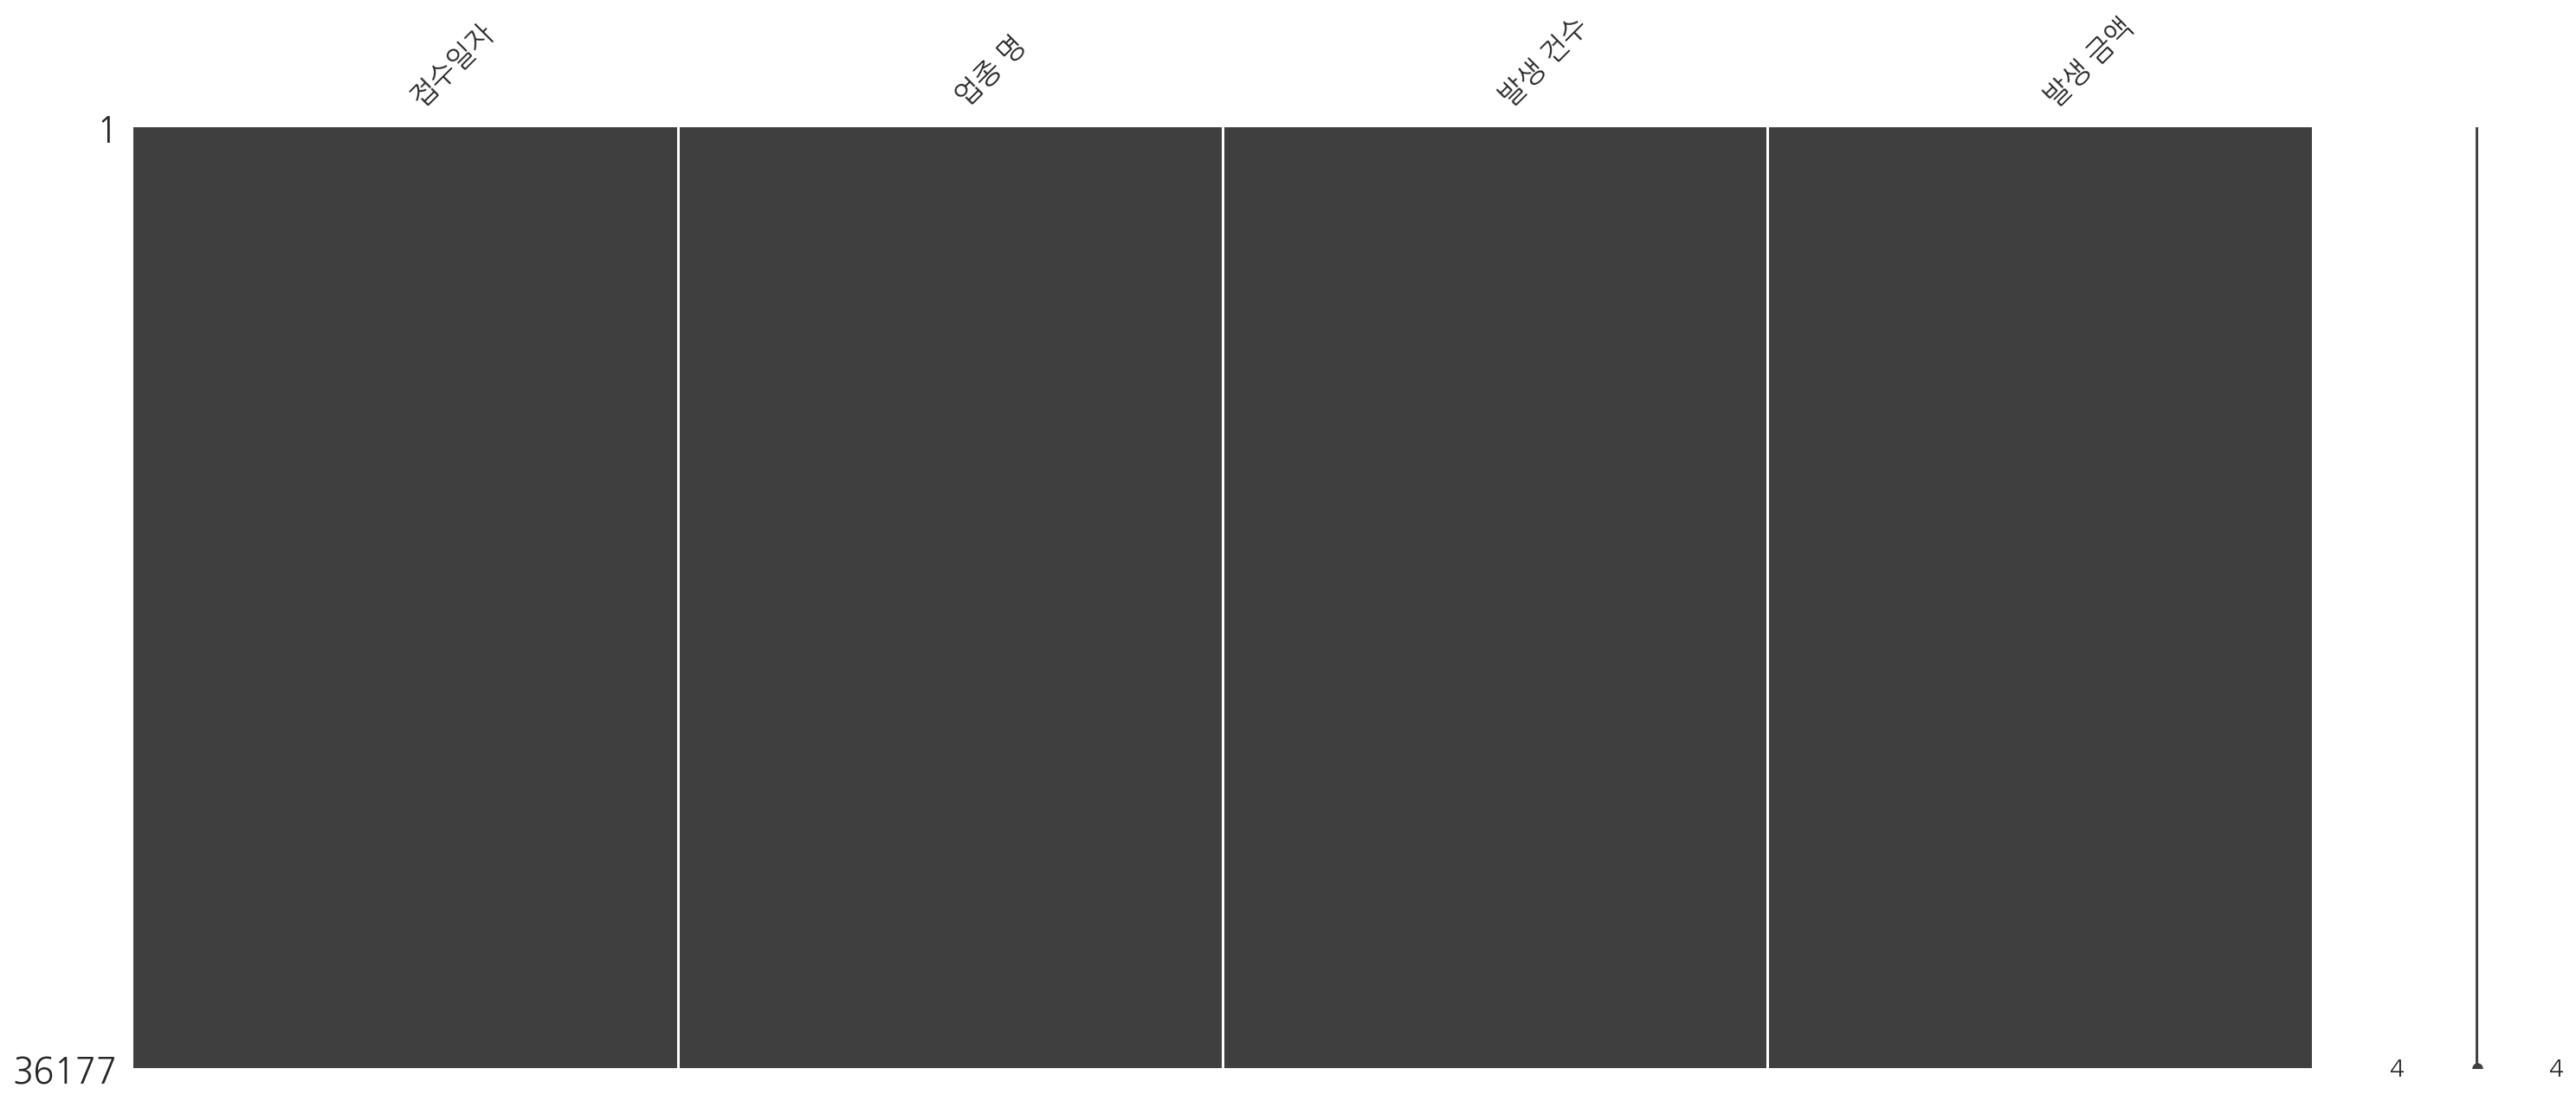

In [10]:
# 결측치 확인
sns.set(font="NanumGothic", 
         rc={"axes.unicode_minus":False},
         style='darkgrid')
missingno.matrix(card3)

In [11]:
import datetime as dt
card_compare = card3.copy()
card_compare = card_compare.groupby(["접수일자", "업종 명"]).mean().reset_index()

card_compare["주"] = pd.to_datetime(card_compare["접수일자"]).dt.week
card_compare.head()

card_compare  = card_compare.groupby(["업종 명","주"]).mean().reset_index()
card_compare.head()

,업종 명,주,발생 건수,발생 금액
0,1급 호텔,1,38.000000,6.941145e+06
1,1급 호텔,2,40.250000,6.593542e+06
2,1급 호텔,3,32.666667,3.869298e+06
3,1급 호텔,4,501.800000,1.017885e+08
4,1급 호텔,5,517.428571,8.460931e+07


In [12]:
# import datetime as dt
# card_compare["주"] = pd.to_datetime(card_compare["발생 건수"]).dt.week
# card_compare = card_compare.groupby(["업종 명","주"]).mean().reset_index()
# card_compare.head()

In [13]:
card_compare2 = card3.copy()
card_compare2["일"] = pd.to_datetime(card_compare2["접수일자"]).dt.day
card_compare2.groupby(["업종 명","일"]).mean().reset_index()

,업종 명,일,발생 건수,발생 금액
0,1급 호텔,1,346.800000,3.497574e+07
1,1급 호텔,2,348.400000,4.689610e+07
2,1급 호텔,3,352.200000,5.313450e+07
3,1급 호텔,4,264.400000,1.648687e+07
4,1급 호텔,5,414.000000,4.830906e+07
...,...,...,...,...
7840,화방표구점,27,143.200000,8.583053e+06
7841,화방표구점,28,169.600000,1.389551e+07
7842,화방표구점,29,191.800000,1.680764e+07
7843,화방표구점,30,178.500000,9.755918e+06


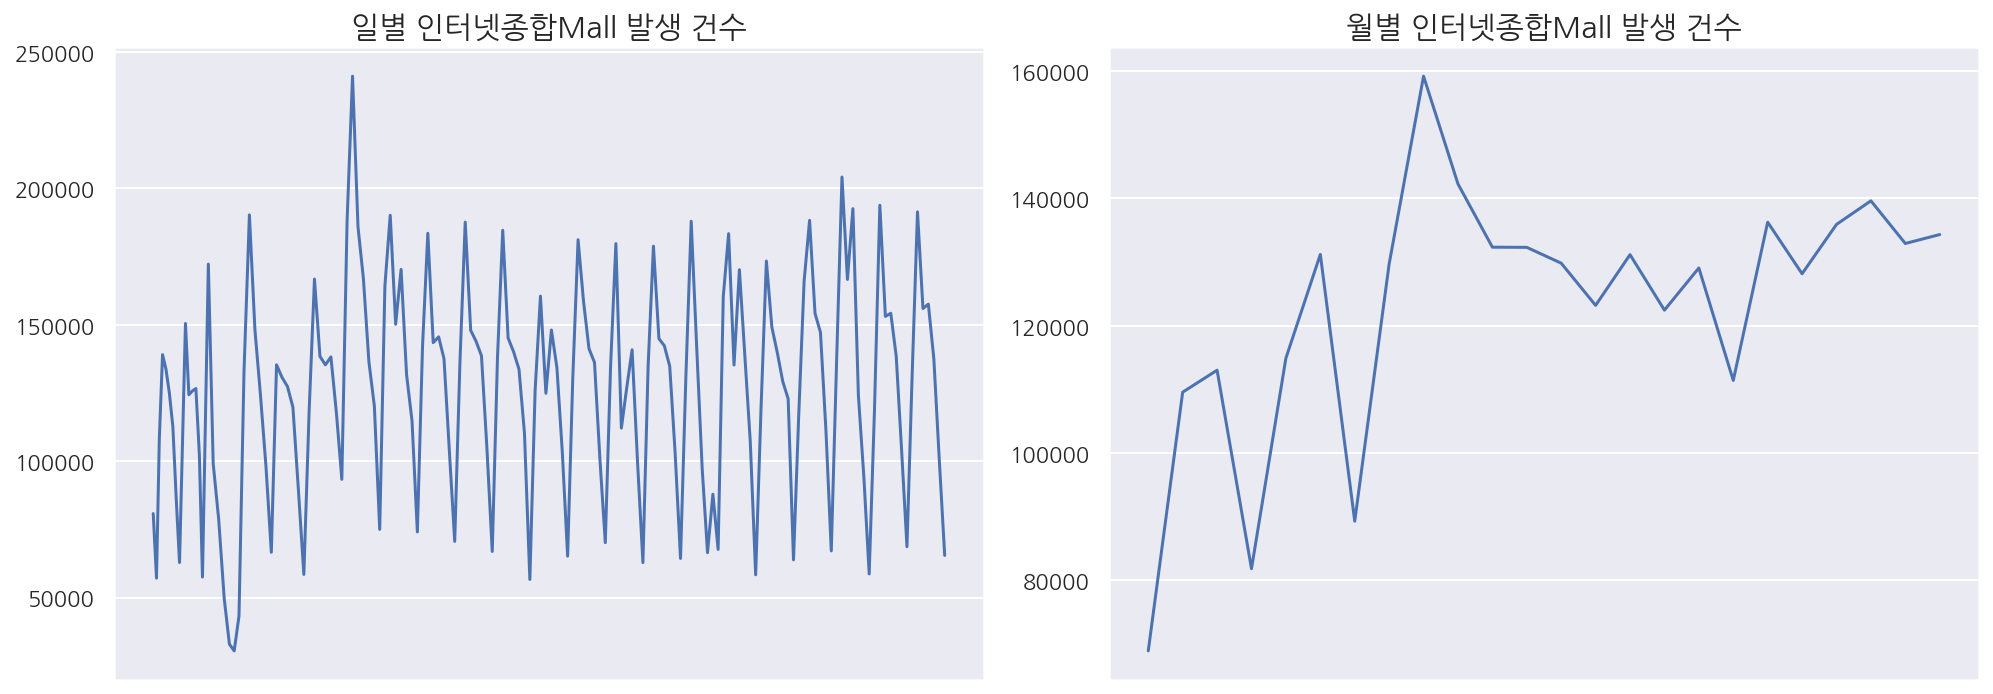

In [14]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(card_compare2[card_compare2['업종 명'] == '인터넷종합Mall']['발생 건수'])
ax[0].set_title("일별 인터넷종합Mall 발생 건수", fontsize=15)
ax[0].set_xticks([])
ax[1].plot(card_compare[card_compare['업종 명'] == '인터넷종합Mall']['발생 건수'])
ax[1].set_title("월별 인터넷종합Mall 발생 건수", fontsize=15)   
ax[1].set_xticks([])
plt.tight_layout()


In [84]:
date = list(card['접수일자'].unique())
category = list(card['업종 명'].unique())
item = [date, category]

from itertools import product
card_temp = pd.DataFrame(product(*item), columns= ['접수일자','업종 명'])

card_to_temp = pd.merge(card3,card_temp,on=['접수일자','업종 명'], how='right')
card_to_temp.head()
card_to_temp = card_to_temp.fillna(0)
card_to_temp = card_to_temp.groupby(['접수일자','업종 명']).mean().reset_index()
card_to_temp.head()
card_to_temp[card_to_temp[["발생 건수", "발생 금액"]].isin([0])].count()

접수일자        0
업종 명        0
발생 건수    4189
발생 금액    4149
dtype: int64

In [85]:
card_to_temp.shape

(40300, 4)

In [132]:
corr = pd.pivot(card_compare[~card_compare["주"].isin([1,2,3])], index="주", columns="업종 명", values="발생 건수").corr()
temp = corr.isnull().sum()

In [133]:
temp[temp > 9]
kind = list(card_compare['업종 명'].unique())

In [134]:
card_compare = card_compare[~card_compare["업종 명"].isin(list(temp[temp > 4].index))]

In [135]:
import scipy.cluster.hierarchy as spc
def hierarchical_clustering(correlation, method, param): 
    pdist = spc.distance.pdist(correlation)
    linkage = spc.linkage(pdist, method=method)
    idx = spc.fcluster(linkage, param * pdist.max(), 'distance')
    cluster = pd.DataFrame({'업종 명':correlation.index, '그룹':idx})   
    return cluster

In [129]:
#업종별로 MinMax Scaling하는 함수
def get_scale(Data, target1, target2):
    Data[target1 + "_sc"] = np.zeros(Data.shape[0])
    Data[target1 + "_sc"] = np.zeros(Data.shape[0])
    
    for kind in Data['업종 명'].unique():
        temp = Data[Data['업종 명'] == kind].copy()
        temp[target1 + "_sc"]  = temp[target1].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        temp[target2 + "_sc"]  = temp[target2].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        index = temp.index
        Data.loc[index,target1 + "_sc"] = temp[target1 + "_sc"]
        Data.loc[index,target2 + "_sc"] = temp[target2 + "_sc"]
    
    return Data

In [136]:
cluster = hierarchical_clustering(corr, 'complete', 0.45)

In [142]:
card_compare = get_scale(card_compare, "발생 금액", "발생 건수")

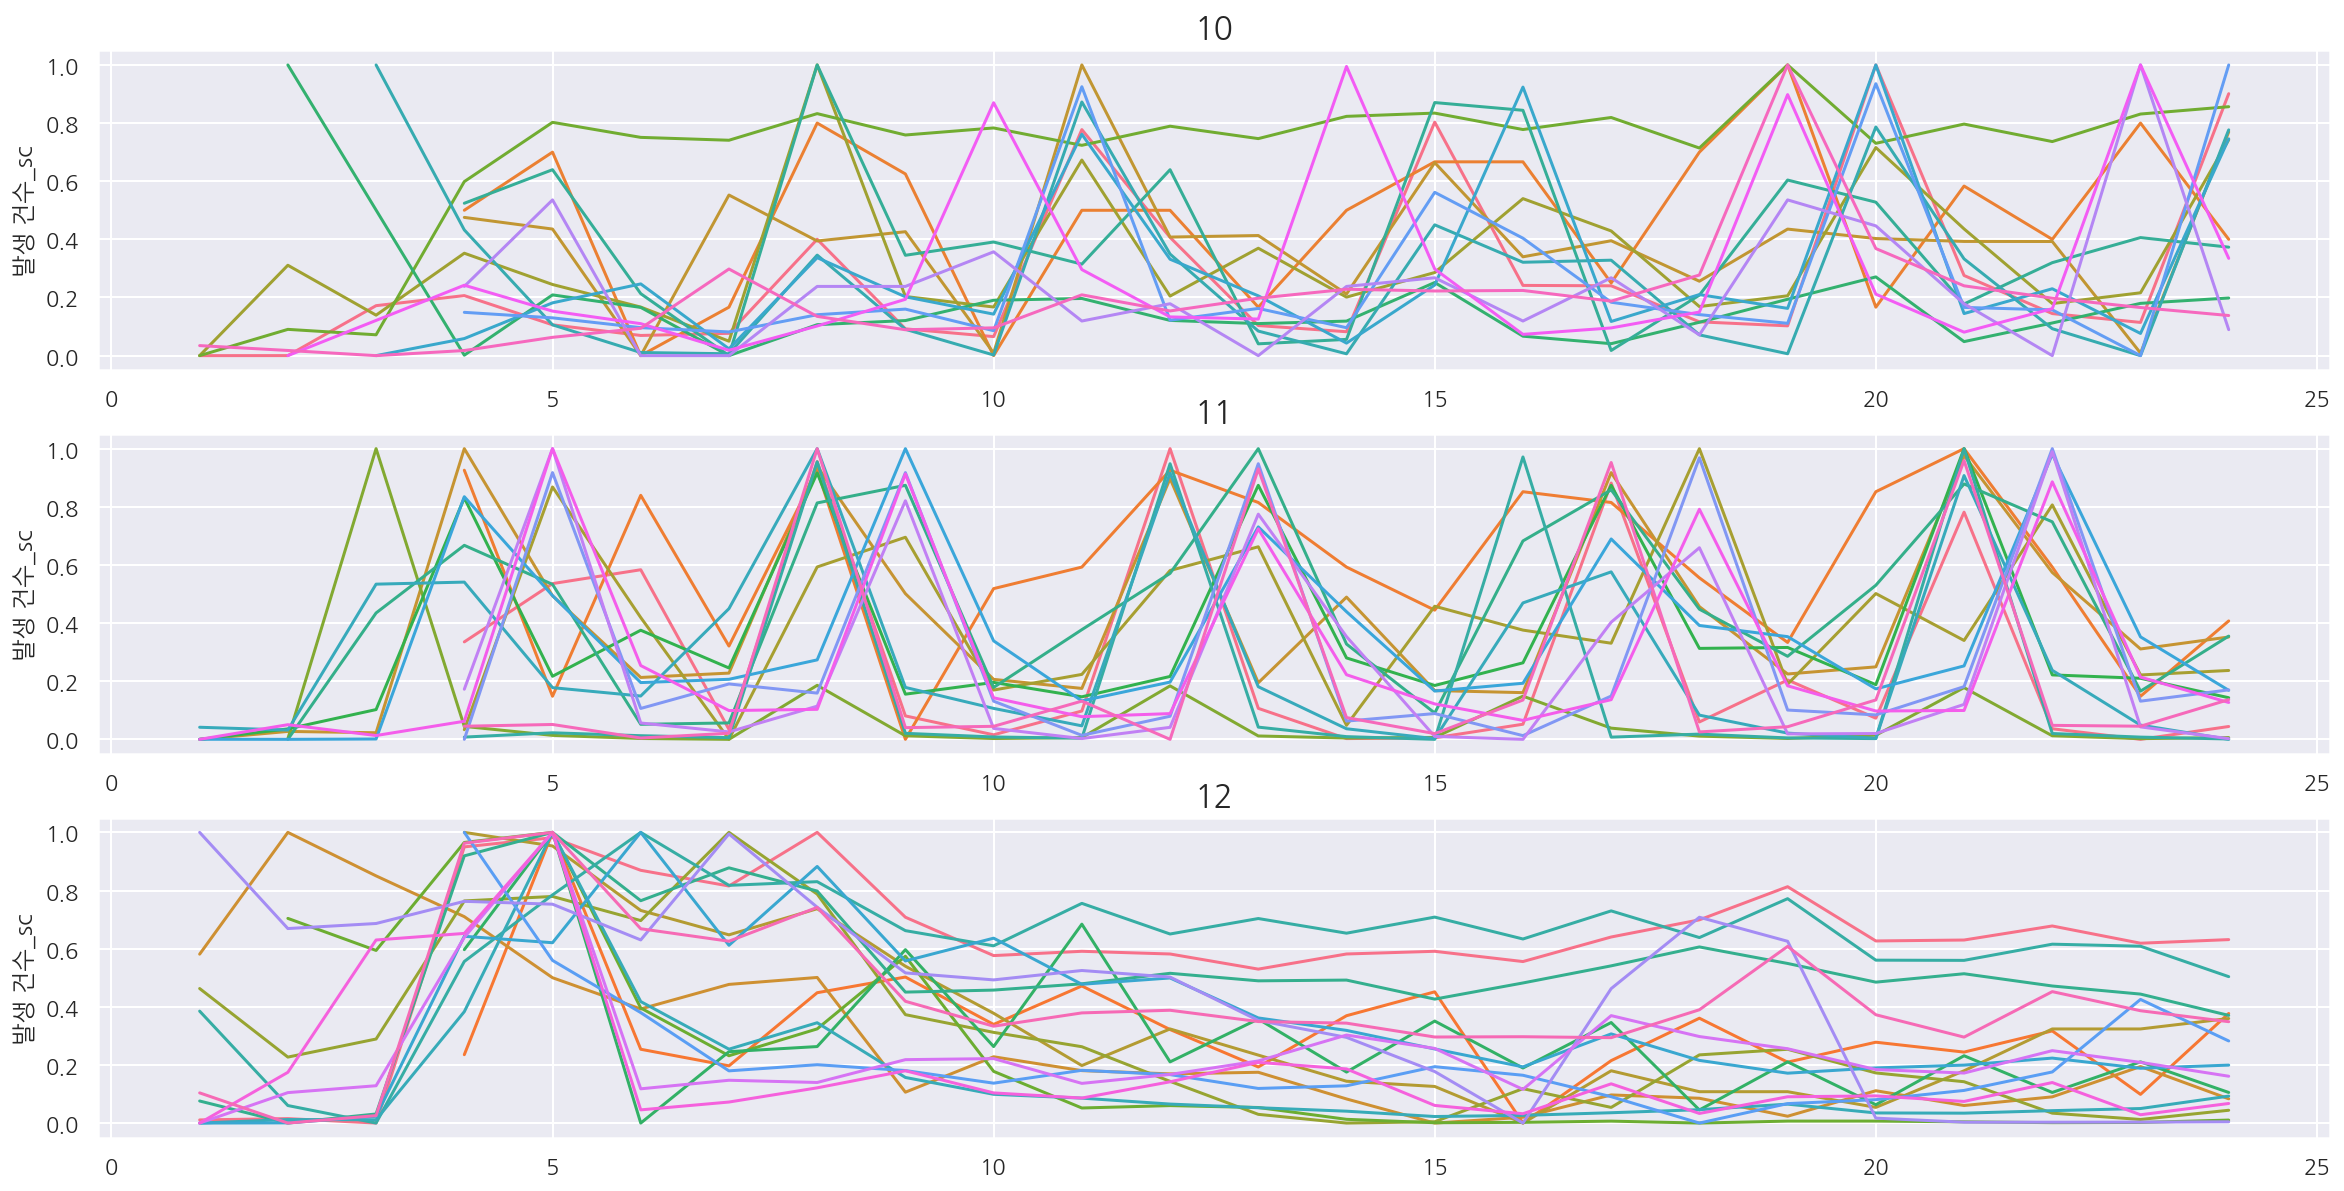

In [146]:
fig,ax = plt.subplots(3,1,figsize=(20,10))
for num,i in enumerate([10,11,12]):
    cluster_kind = list(cluster[cluster['그룹']==i]['업종 명'])
    temp = card_compare[card_compare['업종 명'].isin(cluster_kind)]
    sns.lineplot(temp['주'],temp['발생 건수_sc'],hue=temp['업종 명'],ax=ax[num])
    ax[num].legend().set_visible(False); ax[num].set_xlabel('')
    ax[num].set_title(i, fontsize=16)

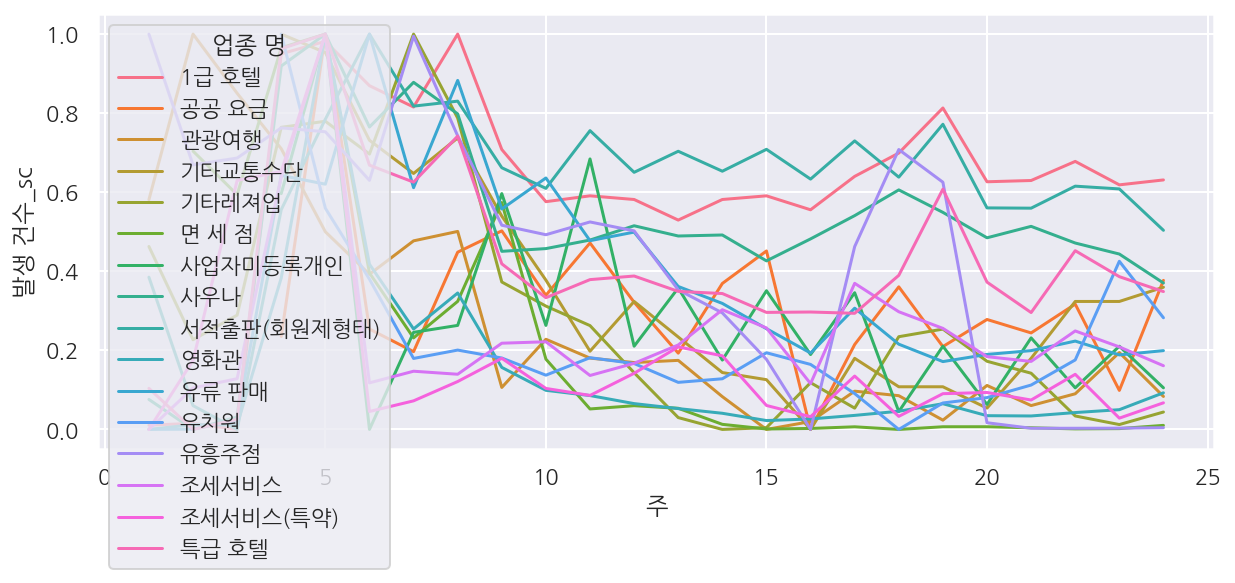

In [178]:
plt.figure(figsize=(10,4))
sns.lineplot(temp['주'],temp['발생 건수_sc'],hue=temp['업종 명'])

In [195]:
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.figure_factory as ff
corr_ma2 = pd.pivot(card_compare[['업종 명','주', "발생 건수"]], index='주', columns='업종 명', values='발생 건수').corr()
pdist = spc.distance.pdist(corr_ma2)
linked = linkage(pdist, 'ward')

fig = ff.create_dendrogram(linked, color_threshold=125)
fig.update_layout(width=800, height=500)
fig.show()